# Food Vision using Covolutional Neural Network

## Project Table of Contents:
* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (making our datasets run fast)
* Creating modelling callbacks
* Setting up mixed precision training
* Building a feature extraction model (see transfer learning part 1: feature extraction)
* Fine-tuning the feature extraction model (see transfer learning part 2: fine-tuning)
* Viewing training results on TensorBoard

---

## Check GPU

For this notebook, we're going to be doing something different.

We're going to be using mixed precision training.

Mixed precision training was introduced in TensorFlow 2.4.0 (a very new feature at the time of writing).

What does `mixed precision training` do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the TensorFlow documentation on mixed precision for more details.

For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible.

For mixed precision training to work, you need **access to a GPU with a compute compability score of 7.0+.**

Google Colab offers P100, K80 and T4 GPUs, however, **the P100 and K80 aren't compatible with mixed precision training.**

Therefore before we proceed we need to make sure we have access to 2x Tesla T4 GPUs in our Kaggle instance.

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7ede28fa-fdea-8d99-9d28-80d03abf6b95)
GPU 1: Tesla T4 (UUID: GPU-5b8c8b52-735c-614a-b203-0bf897dca2b8)


In [4]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.6.4


---

## Getting helper functions

We are going to create a bunch of `helper functions` to do small tasks required for our notebook.

In [5]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-24 18:18:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-24 18:18:37 (48.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
## Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

---

## Use TensorFlow Datasets to Download the Data
If you want to get an overview of Tensorflow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [7]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after ("`food101`") is present.

In [8]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

2023-01-24 18:18:38.971265: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


True


To get access to the Food101 dataset from the TFDS, we can use the tfds.load() method.

In particular, we'll have to pass it a few parameters to let it know what we're after:

* `name` (str) : the target dataset (e.g. "`food101`")
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  - the `split` parameter is quite tricky. See the documentation for more.
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False`
* `as_supervised` (bool) : `True` to download data samples in tuple format ((data, label)) or False for dictionary format
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 Note: Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [9]:
# Load in the data (takes 3-4 minutes in Kaggle)
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, # data gets returned in tuple format (data,label)
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling food101-train.tfrecord...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling food101-validation.tfrecord...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


2023-01-24 18:25:40.939905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:25:40.943180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:25:41.112454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:25:41.113716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:25:41.114553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

---

## Exploring the Food101 data from TensorFlow Datasets

to become one with the data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded?)
* Do the labels match up with the class names

In [10]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [11]:
# Get the Class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

let's take one sample off the training data (using the `.take()` method) and explore it.

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in the format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [13]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [14]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)

2023-01-24 18:25:46.874907: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 72
    Class name (str form): pancakes
    


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [15]:
# What does our image tensor from TFDS's Food10 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 42,  40,  51],
        [ 41,  39,  50],
        [ 40,  38,  49],
        ...,
        [ 50,  23,   6],
        [ 51,  24,   7],
        [ 51,  24,   7]],

       [[ 41,  39,  50],
        [ 41,  39,  50],
        [ 41,  39,  50],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 49,  22,   5]],

       [[ 40,  38,  49],
        [ 41,  39,  50],
        [ 42,  40,  51],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 48,  21,   4]],

       ...,

       [[188, 180, 191],
        [188, 180, 191],
        [189, 181, 192],
        ...,
        [179, 178, 186],
        [177, 176, 184],
        [175, 174, 182]],

       [[185, 177, 188],
        [186, 178, 189],
        [187, 179, 190],
        ...,
        [178, 177, 185],
        [176, 175, 183],
        [175, 174, 182]],

       [[179, 171, 182],
        [181, 173, 184],
        [183, 175, 186],
        ...,
        [177, 176, 18

In [16]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plotting an Image from TensorFlow Datasets

Let's plot one of the image samples using `matplotlib.pyplot.imshow()` and set the title to target class name.

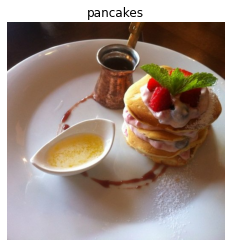

In [17]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Adding title to image to verify the label is associated with the right image
plt.axis(False);

---

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc..).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in orded to get it ready for a neural network, you'll often have to write preprocessing  functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 and 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 and 1) also called normalized tensors generally perform better

Since we're going to be using EfficientNetBX pretrained model from `tf.keras.applications.efficientnet` we don;t need to rescale our data (these architectures have rescaling built-in).
> 🔑 **Note**: Pretrained **EfficientNetBX** models in `tf.keras.applications.efficientnet` (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a `tf.keras.layers.Rescaling layer`.

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [18]:
# (image, label)

In [19]:
# Making a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes
    image to [img_shape, img_shape, colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [20]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[42 40 51]
  [41 39 50]
  [40 38 49]
  ...
  [50 23  6]
  [51 24  7]
  [51 24  7]]

 [[41 39 50]
  [41 39 50]
  [41 39 50]
  ...
  [47 20  3]
  [48 21  4]
  [49 22  5]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[41.127552  39.127552  50.127552 ]
  [40.642857  38.642857  49.642857 ]
  [40.285713  38.285713  49.285713 ]
  ...
  [48.92855   21.928549   4.500022 ]
  [47.7398    20.7398     3.7398005]
  [49.301044  22.301043   5.3010426]]

 [[40.642857  38.642857  49.642857 ]
  [42.9949    40.9949    51.9949   ]
  [41.85714   39.85714   50.85714  ]
  ...
  [49.127533  22.127531   4.699003 ]
  [47.862247  20.862246   3.8622465]
  [48.928574  21.928572   4.9285717]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Looks like our preprocess_img() function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

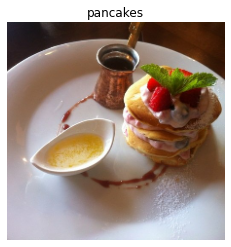

In [21]:
# We can still plot our preprocessed image as long as we divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

---

## Batch & prepare datasets

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the tf.data API.


Specifically, we're going to be using:

* `map()` - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
* shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
* `batch()` - turns elements of a target dataset into batches (size defined by parameter batch_size)
* `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: `cache()` - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:

* Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our preprocess_img() function)
* `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
* For methods with the num_parallel_calls parameter available (such as map()), setting it tonum_parallel_calls=tf.data.AUTOTUNE will parallelize preprocessing and significantly improve speed
* Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

**Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
This is like saying:**

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

In [22]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

And now let's check out what our prepared datasets look like.

In [23]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Looks like our data is now in tutples of (image, label) with datatypes of (tf.float32, tf.int64), just what our model is after.

> 🔑 Note: You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to `prefetch()`.

---

## Create modelling callbacks
Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:

* `tf.keras.callbacks.TensorBoard()` - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* `tf.keras.callbacks.ModelCheckpoint()` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [24]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

---

## Setup mixed precision training
We touched on mixed precision training above.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as single-precision floating-point format. The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means half-precision floating-point format. And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.


let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the `tensorflow.keras.mixed_precision` API has made it very easy for us to get started.

First, we'll import the API and then use the `set_global_policy()` method to set the dtype policy to "`mixed_float16`".

In [25]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

2023-01-24 18:25:49.279420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:25:49.281642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the `mixed_precision.global_policy()` method.

In [26]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

Great, since the global dtype policy is now "`mixed_float16`" our model will automatically take advantage of `float16` variables where possible and in turn speed up training.

---

## Build feature extraction model

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model `(EfficienetNetB0)`.

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

To build the feature extraction model, we'll:

* Use `EfficientNetB0` from `tf.keras.applications` pre-trained on ImageNet as our base model
* We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a Functional model
* Compile the Functional model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels aren't one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

> 🔑 Note: Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations).


In [27]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [28]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


---

## Checking layer dtype policies (are we using mixed precision?)

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [29]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 Note: A layer can have a dtype of `float32` and a dtype policy of "`mixed_float16`" because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.

In [30]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

> 🔑 Note: The mixed precision API automatically causes layers which can benefit from using the "`mixed_float16`" dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

---

## Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [31]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

2023-01-24 18:25:53.176184: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 18:25:53.176235: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-24 18:25:53.179117: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2023-01-24 18:25:53.563782: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 18:25:53.563979: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230124-182553
Epoch 1/3


2023-01-24 18:26:02.584022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/2368 [..............................] - ETA: 10:19:02 - loss: 4.7203 - accuracy: 0.0000e+00

2023-01-24 18:26:09.724627: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 18:26:09.724675: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2368 [..............................] - ETA: 41:54 - loss: 4.7022 - accuracy: 0.0000e+00   

2023-01-24 18:26:10.602177: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-24 18:26:10.604062: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-24 18:26:10.775004: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1222 callback api events and 1219 activity events. 
2023-01-24 18:26:10.821728: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 18:26:10.888264: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230124-182553/train/plugins/profile/2023_01_24_18_26_10

2023-01-24 18:26:10.919204: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230124-182553/train/plugins/profile/2023_01_24_18

2368/2368 [==============================] - 211s 83ms/step - loss: 1.8191 - accuracy: 0.5582 - val_loss: 1.2285 - val_accuracy: 0.6753
Epoch 2/3
2368/2368 [==============================] - 188s 78ms/step - loss: 1.2933 - accuracy: 0.6669 - val_loss: 1.1216 - val_accuracy: 0.6999
Epoch 3/3
2368/2368 [==============================] - 188s 78ms/step - loss: 1.1433 - accuracy: 0.7026 - val_loss: 1.0872 - val_accuracy: 0.7132


In [32]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 51s 65ms/step - loss: 1.0951 - accuracy: 0.7042


[1.0950974225997925, 0.7041584253311157]

And since we used the `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.

Let's load it in and make sure it performs just as well.

---

## Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extraction model with reset weights.
2. Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [33]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [34]:
# Where are our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [35]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

Each time you make a change to your model (including loading weights), you have to recompile.

In [36]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [37]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 52s 63ms/step - loss: 1.7209 - accuracy: 0.5507


Our cloned model with loaded weight's results should be very close to the feature extraction model's results (if the cell below errors, something went wrong).

In [38]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

AssertionError: Loaded weights results are not close to original model.

Cloning the model preserves `dtype_policy`'s of layers (but doesn't preserve weights) so if we wanted to continue fine-tuning with the cloned model, we could and it would still use the mixed precision dtype policy.

In [39]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

---

## Save the whole model to file

We can also save the whole model using the `save()` method.

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

In [40]:
## Saving model to Google Drive (optional)
import os
# # Create save path to drive 
save_dir = "/kaggle/working/food_vision_project/Food-Vision-using-CNN-and-TransferLearning/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

2023-01-24 18:37:51.743188: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [41]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

Loading a `SavedModel` also retains all of the underlying layers `dtype_policy` (we want them to be "`mixed_float16`").

In [42]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [43]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 52s 64ms/step - loss: 1.0951 - accuracy: 0.7042


[1.0950984954833984, 0.7041584253311157]

In [44]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

That's what we want! Our loaded model performing as it should.

> 🔑 Note: We spent a fair bit of time making sure our model saved correctly because training on a lot of data can be time-consuming, so we want to make sure we don't have to continaully train from scratch.

---

## Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

> 🔑 Note: It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data (feature extraction). And then unfreeze a number or all of the layers in the base model and continue training until the model stops improving.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

We can download it to make sure we're using the same model going forward.

In [45]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2023-01-24 18:39:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.213.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  48.6MB/s    in 0.3s    

2023-01-24 18:39:52 (48.6 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [46]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [47]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [48]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


And now let's make sure our loaded model is performing as expected.

In [49]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 52s 63ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0881211757659912, 0.7065742611885071]

Great, our loaded model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting `base_model.trainable=False` but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [54]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Alright, it seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model?

> Question: Which layer in the loaded model is our base model?

Before saving the Functional model to file, we created it with five layers (layers below are 0-indexed): 0. The input layer

1. The pre-trained base model layer (`tf.keras.applications.EfficientNetB0`)
2. The pooling layer
3. The fully-connected (dense) layer
4. The output softmax activation (with float32 dtype)

Therefore to inspect our base model layer, we can access the `layers` attribute of the layer at index 1 in our model.

In [50]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <P

Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy "`mixed_policy16`" is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

> 🔑 Note: If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

---

## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

> Question: When do you stop training?

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the `EarlyStopping` callback.

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training.

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [51]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

If you're planning on training large models, the `ModelCheckpoint` and `EarlyStopping` are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: `ReduceLROnPlateau`.

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

In [52]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

Learning rate reduction ready to go!

Now before we start training, we've got to recompile our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (`1e-4` instead of `1e-3`).

In [53]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the `EarlyStopping` callback, it might stop before reaching 100 epochs.

In [55]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

2023-01-24 18:42:01.933366: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 18:42:01.933409: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-24 18:42:03.263489: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 18:42:03.263693: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230124-184201
Epoch 1/100
   1/2368 [..............................] - ETA: 6:44:43 - loss: 1.2477 - accuracy: 0.6562

2023-01-24 18:42:14.082292: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 18:42:14.082336: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2368 [..............................] - ETA: 47:07 - loss: 1.0745 - accuracy: 0.7031  

2023-01-24 18:42:16.095152: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-24 18:42:16.098678: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-24 18:42:16.276052: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1222 callback api events and 1219 activity events. 
2023-01-24 18:42:16.332900: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 18:42:16.414132: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230124-184201/train/plugins/profile/2023_01_24_18_42_16

2023-01-24 18:42:16.446030: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/efficientb0_101_classes_all_data_fine_tuning/20230124-184201/train/plugins/profile/2023_01_24_18_42_16/e9516c6

   4/2368 [..............................] - ETA: 36:49 - loss: 1.2708 - accuracy: 0.6562

2023-01-24 18:42:16.560025: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230124-184201/train/plugins/profile/2023_01_24_18_42_16

2023-01-24 18:42:16.568822: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to training_logs/efficientb0_101_classes_all_data_fine_tuning/20230124-184201/train/plugins/profile/2023_01_24_18_42_16/e9516c6bb2b7.memory_profile.json.gz
2023-01-24 18:42:16.572614: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230124-184201/train/plugins/profile/2023_01_24_18_42_16
Dumped tool data for xplane.pb to training_logs/efficientb0_101_classes_all_data_fine_tuning/20230124-184201/train/plugins/profile/2023_01_24_18_42_16/e9516c6bb2b7.xplane.pb
Dumped tool data for overview_page.pb to training_logs/efficientb0_101_classes_

2368/2368 [==============================] - 203s 81ms/step - loss: 0.9717 - accuracy: 0.7505 - val_loss: 1.0483 - val_accuracy: 0.7185


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
2368/2368 [==============================] - 188s 78ms/step - loss: 0.9548 - accuracy: 0.7577 - val_loss: 1.0425 - val_accuracy: 0.7211


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
2368/2368 [==============================] - 191s 79ms/step - loss: 0.9439 - accuracy: 0.7600 - val_loss: 1.0445 - val_accuracy: 0.7227
Epoch 4/100
2368/2368 [==============================] - 187s 78ms/step - loss: 0.9342 - accuracy: 0.7626 - val_loss: 1.0380 - val_accuracy: 0.7251


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
2368/2368 [==============================] - 190s 78ms/step - loss: 0.9255 - accuracy: 0.7644 - val_loss: 1.0430 - val_accuracy: 0.7198
Epoch 6/100
2368/2368 [==============================] - 188s 78ms/step - loss: 0.9172 - accuracy: 0.7658 - val_loss: 1.0300 - val_accuracy: 0.7275


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
2368/2368 [==============================] - 193s 80ms/step - loss: 0.9092 - accuracy: 0.7691 - val_loss: 1.0432 - val_accuracy: 0.7214
Epoch 8/100
2368/2368 [==============================] - 189s 79ms/step - loss: 0.9016 - accuracy: 0.7712 - val_loss: 1.0394 - val_accuracy: 0.7219

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 9/100
2368/2368 [==============================] - 196s 81ms/step - loss: 0.8853 - accuracy: 0.7765 - val_loss: 1.0350 - val_accuracy: 0.7233


> 🔑 Note: If you didn't use mixed precision or use techniques such as `prefetch()` in the Batch & prepare datasets section, your model fine-tuning probably takes up to 2.5-3x longer per epoch (see the output below for an example).

|        | Prefetch and mixed precision | No prefetch and no mixed precision |
| ---------- | ---------- | ------------ |
| Time per epoch | ~280-300s | ~1127-1397s |

Results from fine-tuning 🍔👁 Food Vision Big™ on Food101 dataset using an EfficienetNetB0 backbone using a Kaggle 2x Tesla T4 GPU.


results

Let's make sure we save our model before we start evaluating it.

In [56]:
# Save model to Kaggle output directory
loaded_gs_model.save("/kaggle/working/food_vision_project/Food-Vision-using-CNN-and-TransferLearning")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


---

## View training results on TensorBoard
Since we tracked our model's fine-tuning training logs using the `TensorBoard` callback, let's upload them and inspect them on TensorBoard.dev.

In [57]:
# Upload experiment results to TensorBoard (uncomment to run)
# !tensorboard dev upload --logdir ./training_logs \
#   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
#   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
#   --one_shot

Viewing at our model's training curves on TensorBoard.dev, it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.

See the training curves on TensorBoard.dev here: https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/

To fix this, in future experiments, we might try things like:

* A different iteration of `EfficientNet` (e.g. `EfficientNetB4` instead of `EfficientNetB0`).
* Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.

In [58]:
# View past TensorBoard experiments
# !tensorboard dev list

In [59]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID

# Example
# !tensorboard dev delete --experiment_id OAE6KXizQZKQxDiqI3cnUQ

# End of the project